# COMP24111 - Exercise 3: _Face recognition_

## 1. Task description

You will work on a face recognition task. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from numpy.linalg import inv

Now you can load the data:

In [2]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

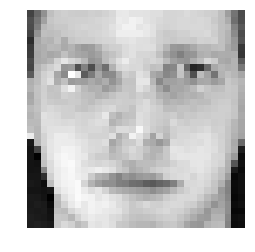

In [3]:
# Display a single example.
show_single_face(data[0, :])

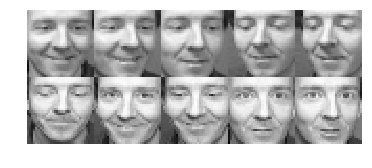

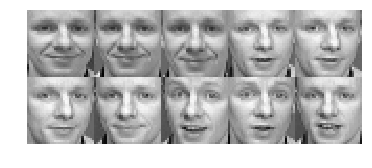

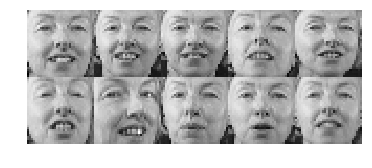

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[20:30, :], num_per_row=5)
show_faces(data[200:210, :], num_per_row=5)
show_faces(data[310:320, :], num_per_row=5)

### Splitting into train and test set

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:

tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]
print(tr_data.shape)
print(tr_data)
print(tr_label.shape)



NameError: name 'tr_ind' is not defined

## 3. $L_2$-regularised least squares implementation

Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss using the normal equations (this is called $L_2$*-regularised least squares model*, or *ridge regression model*). It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights.

In [ ]:
def l2_rls_train(tr_data, tr_labels, lamda, sample_no):
    """
    A summary of your function goes here.
    for my own understanding:
    matrix X is my data matrix (120, 1024) dimensions. each row contains the pixel count 1-256 for 1024 pixels.
    every 3 rows is a new image.
    matrix Y is the labels matirx saying which classes these samples are from
    data: the data for each sample is a row in the overall matrix with 1024 slots - each contains a value from 1 - 256
    regarding the greyscale of the pixel
    labels: The labesl are the assiging values for eacfh image - a number from 1 - 40 assigning it to a class.
    to calculate least squares i must first create disciminant function. y = f(x) to make this though i need my weight 
    vectors. 
    Returns: type and description of the returned variable(s).
    """
    
    #for refernece matrix manipulation
    #https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    # This is just to be consistent with the lecture notes.
    X, y = tr_data, tr_labels
    
    # Expand X with a column of ones.
    X0 = np.ones((sample_no,1))
    X_tilde = np.hstack((X0, X))
    #print(X_tilde)
    
    # Compute the coefficient vector.
    #i was going to use the pusedo inverse of x_tilde however i was unsure abput the manipulation as lamda is inside
    #the bracket. eg W = X_tilde^+ * y W = (x_tilde^T * x_tilde + λ * I) ^-1 * x_tilde^T * y
    #going to do the calcualtion in steps for understanding and minimsign errors
    
    #when lamada is zero - the pusedo inverse can be used else we must use the long equation
    if(lamda == 0):
        w = np.linalg.pinv(X_tilde) @ y
        
    #x_tilde matirc multiplication will have a  (1025, 120) * (120, 1025) so result be (1025, 1025)
    #identity matrix
    else:
        i = np.eye(1025)
        i_scaled = i*lamda
    
    #new matrix for x_tilde_transposed going to shorten name
        X_transposed = X_tilde.transpose()
    
    #w will be returned as a (1025, 1) matrix - all weights will be in a column w0 - w1024
        w = inv((X_transposed @ X_tilde) + i_scaled) @ (X_transposed @ y)
    
    
    # Return model parameters.
    return w

Once you have trained your model, you can use it on to predict new data. Implement the following function to do this.

In [ ]:
def l2_rls_predict(w, data, sample_no # Add any other arguments here
                  ):
    """
This function is predicting the 'plot' as such from your previuosly created linear discriminant function
It takes the new data (x, 1024) and again adds a column of 1 to the front. x is defined as sample number
    """
    
    # This is just to be consistent with the lecture notes.
    X = data
    X0 = np.ones((sample_no,1))
    X_tilde = np.hstack((X0, X))
    
    #we then multiply our(x, 1025) by w (1025, 1) to give an (x, 1) matrix this represents a column of each predicted y
    #value for each sample
    
    #predicted_y = X_tilde @ w
    predicted_y = X_tilde @ w
    
    return predicted_y

## 4. Experiments

Start to use your functions `l2_rls_train` and `l2_rls_predict` to perform the following experiments.

### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” to train a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” to train a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” to train a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [ ]:
def exp1(label_class_1, label_class_30):
    # Map the labels and partition the data

    tr_ind_1, te_ind_1 = partition_data(labels[0:10], num_per_class=3)
    tr_ind_30, te_ind_30 = partition_data(labels[290:300], num_per_class=3)
    
    #print(tr_ind_30)
    #print(te_ind_30)
    
    #changing the indicies back to values between 290 and 300
    for x in range (len(tr_ind_30)):
        value = tr_ind_30[x]
        tr_ind_30[x] = value + 290
    for x in range (len(te_ind_30)):
        value = te_ind_30[x]
        te_ind_30[x] = value + 290
    
    #print(tr_ind_30)
    #print(te_ind_30)
    #i need to sort out the indicie problem, passing a sliced array is changing the indices 
    #hence not giving me sample 30 but sample 1
    tr_data_1 = data[tr_ind_1, :]
    te_data_1 = data[te_ind_1, :]
    tr_data_30 = data[tr_ind_30, :]
    te_data_30 = data[te_ind_30, :]
    
    tr_data = np.vstack((tr_data_1, tr_data_30))
    te_data = np.vstack((te_data_1, te_data_30))
    
    #tr_data should be a (6, 1024) te_data a (14, 1024)
    #print("training data matrix")
    #print(tr_data.shape)
    #print("test data matrix")
    #print(te_data)
    
    #getting my labels from the partinioned data
    tr_labels_1 = labels[tr_ind_1]
    te_labels_1 = labels[te_ind_1]
    tr_labels_30 = labels[tr_ind_30]
    te_labels_30 = labels[te_ind_30]
    
    #change the training labels to the values passed as parameters
    tr_labels = np.concatenate((tr_labels_1, tr_labels_30), axis=None)
    te_labels = np.concatenate((te_labels_1, te_labels_30), axis=None)
    #print(tr_labels)
    #print(te_labels)
    tr_labels = np.where(tr_labels==1, label_class_1, tr_labels)
    tr_labels = np.where(tr_labels==30, label_class_30, tr_labels)
    te_labels = np.where(te_labels==1, label_class_1, te_labels)
    te_labels = np.where(te_labels==30, label_class_30, te_labels)
    #print(tr_labels)
    #print("train data new labels")
    #print(tr_labels.shape)
    #print("test data new labels")
    #print(te_labels)
    
    
    
    
    # Train your model
    w = l2_rls_train(tr_data, tr_labels, 0, len(tr_data))
    #print("weighted sum vector")
    #print(w)
    #print(w.shape)
    
    #predicted y will be a column vector that has predicted a value for each of the 14 images
    predicted_y_te = l2_rls_predict(w, te_data, len(te_data))
    #print("predicted_y for test data")
    #print(predicted_y_te)
    #print(predicted_y_te.shape)
    predicted_y_te = predicted_y_te.transpose()
    #print(predicted_y_te.shape)
    
    # Define the threshold
    T = ((label_class_1 + label_class_30) / 2)
    
    predicted_y_te = np.where(predicted_y_te<T, label_class_1, predicted_y_te)
    predicted_y_te = np.where(predicted_y_te>T, label_class_30, predicted_y_te)
    print("test y assigned to classes with threshhold:", T)
    print(predicted_y_te)
    #change test class labels to floats so you can compare them
    te_labels = te_labels.astype('float64')
    print("test data new labels")
    print(te_labels)
    te_err = ((len(te_labels) - np.sum(te_labels == predicted_y_te)) / len(tr_labels))
    print("testing error rate")
    print(te_err)
    print()
    
    # Perform prediction for training and compute the training error
    predicted_y_tr = l2_rls_predict(w, tr_data, len(tr_data))
    #print("predicted_y for train data")
    #print(predicted_y_tr)
    predicted_y_tr = predicted_y_tr.transpose()
    
    predicted_y_tr = np.where(predicted_y_tr<T, label_class_1, predicted_y_tr)
    predicted_y_tr = np.where(predicted_y_tr>T, label_class_30, predicted_y_tr)
    print("train y assigned to classes with threshhold:", T)
    print(predicted_y_tr)
    #change test class labels to floats so you can compare them
    tr_labels = tr_labels.astype('float64')
    print("train data new labels")
    print(tr_labels)
    tr_err = ((len(tr_labels) - np.sum(tr_labels == predicted_y_tr)) / len(tr_labels))
    print("training error rate")
    print(tr_err)
    print()
    print()
    
    
    
    return te_err, tr_err

In [ ]:
# Use the `exp1()` function to experiment with classifier 1.
# Your code goes here.
#get only images from subjects 1 and 30

training_error_array_1 = []
testing_error_array_1 = []
for i in range(50):
    s = "EXPERIMENT "
    print(s + "{}".format(i))
    result = exp1(-1, 1)
    training_error_array_1.append(result[1])
    testing_error_array_1.append(result[0])
print("TRAINING ERROR ARRAY")
print(training_error_array_1)
print("TESTING ERROR ARRAY")
print(testing_error_array_1)

Repeat the same experiment for classifier 2.

In [ ]:
training_error_array_2 = []
testing_error_array_2 = []
for i in range(50):
    s = "EXPERIMENT "
    print(s + "{}".format(i))
    result = exp1(0, 1)
    training_error_array_2.append(result[1])
    testing_error_array_2.append(result[0])
print("TRAINING ERROR ARRAY")
print(training_error_array_2)
print("TESTING ERROR ARRAY")
print(testing_error_array_2)


Repeat the same experiment for classifier 3.

In [ ]:
training_error_array_3 = []
testing_error_array_3 = []
for i in range(50):
    s = "EXPERIMENT "
    print(s + "{}".format(i))
    result = exp1(1, 30)
    training_error_array_3.append(result[1])
    testing_error_array_3.append(result[0])
print("TRAINING ERROR ARRAY")
print(training_error_array_3)
print("TESTING ERROR ARRAY")
print(testing_error_array_3)

Print the test error mean and standard deviation of the three classifiers and display them in the same plot.

In [ ]:
mean_array_te = []
std_array_te = []
mean_array_tr = []
std_array_tr = []

print("CLASSIFIER 1")
mean_tr_1 = np.mean(training_error_array_1)
print(" TRAINING MEAN", mean_tr_1)
mean_array_tr.append(mean_tr_1)
std_tr_1 = np.std(training_error_array_1)
print(" TRAINING STD ", std_tr_1)
std_array_tr.append(std_tr_1)
print()
mean_te_1 = np.mean(testing_error_array_1)
mean_array_te.append(mean_te_1)
print(" TESTING MEAN", mean_te_1)
std_te_1 = np.std(testing_error_array_1)
std_array_te.append(std_te_1)
print(" TESTING STD ", std_te_1)
print()
print()
print("CLASSIFIER 2")
mean_tr_2 = np.mean(training_error_array_2)
mean_array_tr.append(mean_tr_2)
print(" TRAINING MEAN", mean_tr_2)
std_tr_2 = np.std(training_error_array_2)
std_array_tr.append(std_tr_2)
print(" TRAINING STD ", std_tr_2)
print()
mean_te_2 = np.mean(testing_error_array_2)
mean_array_te.append(mean_te_2)
print(" TESTING MEAN", mean_te_2)
std_te_2 = np.std(testing_error_array_2)
std_array_te.append(std_te_2)
print(" TESTING STD ", std_te_2)
print()
print()
print("CLASSIFIER 3")
mean_tr_3 = np.mean(training_error_array_3)
mean_array_tr.append(mean_tr_3)
print(" TRAINING MEAN", mean_tr_3)
std_tr_3 = np.std(training_error_array_3)
std_array_tr.append(std_tr_3)
print(" TRAINING STD ", std_tr_3)
print()
mean_te_3 = np.mean(testing_error_array_3)
mean_array_te.append(mean_te_3)
print(" TESTING MEAN", mean_te_3)
std_te_3 = np.std(testing_error_array_3)
std_array_te.append(std_te_3)
print(" TESTING STD ", std_te_3)
print()
print()

#format copied from lab 1 python tutorial
x = ['1', '2', '3']
plt.ylabel('Mean Error')
plt.xlabel('Classifier')
plt.title('Training Accuracy')
plt.errorbar(x, mean_array_tr, std_array_tr, ecolor='g')
plt.show()

#format copied from lab 1 python tutorial
x = ['1', '2', '3']
plt.ylabel('Mean Error')
plt.xlabel('Classifier')
plt.title('Testing Accuracy')
plt.errorbar(x, mean_array_te, std_array_te, ecolor='g')
plt.show()


Compare the three classifiers and comment on your results.

What training accuracies do you obtain with your linear classifier? Explain the reason.

Between subjects “1” and “30”, which one is more difficult for the linear classifier to recognise? Explain it.

### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects. Decide an appropriate way to set your target output and make class prediction. 

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. 

Write your code below and make sure it compiles. Show your code to the TA, explain your classifier and experiment design.

In [6]:
#this function taken from stack overflow
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def hyperparameter_selection(tr_ind):
    
    """so notes for myself - frist data is partioned into 200:200 hence 5 images from each of the 40 subjects passed to 
    hyperparameter selection. then data is split again image 1 from each subject for testing other 4 for training, and this 
    is doen 5 times for each lamda i try. the error between 5 trials gives the error for this lamda value. after the laamda with the minimum 
    error rate is chosen, we retrain using all 200 training samples and test with 200 untouched samples"""

    #first i get labels for all 200 images
    tr_labels = labels[tr_ind]
    #print(tr_ind)
    #print(tr_labels)
    #print(tr_labels)
    
    lamda_value = []
    error_per_lamda = []
    
    
    #initally i had my lamda as going from 0 to 21 however i observed no change in the error rate. looking at the notes
    #from ch6 pg 36 i can see there is a log relationship and performs best when log10(lamda) about 5.
    #i used a log for loop i found online
    #https://stackoverflow.com/questions/11443737/how-to-generate-exponentially-increasing-range-in-python
    numbers_sizes = (10**exp for exp in range(1, 7))
    for lamda in numbers_sizes:
        
        error_per_kfold = []
        #I am going to do 5 fold hence willl take out 1 image from each class for testing and have 4 from each for training.
        #making an array of 40 images for testing and 160 for training
        
        te_ind_1 = []
        tr_ind_1 = []
        
        for i in range(0, 200):
            if(i%5 == 0):
                te_ind_1.append(tr_ind[i])
            else:
                tr_ind_1.append(tr_ind[i])
            
        #print(tr_ind_1)
        #print(te_ind_1)
        #tr_data_1 is my x value
        tr_data_1 = data[tr_ind_1]
        te_data_1 = data[te_ind_1]
        tr_labels_1 = labels[tr_ind_1]
        te_labels_1 = labels[te_ind_1]
        #print(tr_labels_1)
        
        #making my y i am going to start with a row of ones to attach the rows to with vstack then remove this top row
        #after. so the y matrix will be 160 down and 40 across with one '1' per row indicating which class its from
        
        #tr_labels_1 is my y value however I need to change this from a 0, 160 to a (160, 40) matrix where each
        #row has 1 1 and 39 zeros indicating its class
        
        #this is just a row of ones to attach all the other rows to , i will delete after.
        y_matrix_1 = np.ones((40))
        
        #make a row of zeros, the class - 1 is the column index indicating that class, add each row inturn to ymatrix
        for i in range(160):
            y = np.zeros((40))
            #which colum number will be made zero
            y_class = (tr_labels_1[i] - 1)
            y[y_class] = 1
            y_matrix_1 = np.vstack((y_matrix_1, y))
        
        #chop off top row of y_matrix
        y_matrix_1 = np.delete(y_matrix_1, (0), axis=0)
        #print(y_matrix_1.shape)
        #now we train using the tr_data_ 1 and y_matrix to get weight matrix
        #print(lamda)
        w1 = l2_rls_train(tr_data_1, y_matrix_1, lamda, len(tr_data_1))
        #print(w1.shape)
        #the w matrix represents the weight for each feature for each class,
        
        #now we test with the 40 test samples using this calculated w
        predicted_y_1_matrix = l2_rls_predict(w1, te_data_1, len(te_data_1))
        #predicted y comes out as 40 down represeting each testing sample and 40 across representing which class its from
        
        #print(predicted_y_1_matrix)
        #now we must take matrix and turn it into an array representing which class its from. it will be assigned to class
        #for value in row closest to 1. find nearest function defined above
        #print(predicted_y_1_matrix)
        predicted_y_1 = []
        for i in range(40):
            this_row = predicted_y_1_matrix[i]
            nearest_class = (find_nearest(this_row, 1) + 1)
            predicted_y_1.append(nearest_class)
        
        #print("for lamda = ", lamda, "in the first k fold:")
        te_err_1 = ((len(te_labels_1) - np.sum(te_labels_1 == predicted_y_1)) / len(te_labels_1))
        error_per_kfold.append(te_err_1)
        
        
        
        #now repeat all steps for 2nd, 3rd, 4th, 5th fold and then caluculate overall error for this lamba value
        te_ind_2 = []
        tr_ind_2 = []
        
        #now we want the 1, 6, 11, 16 etc indicie for testing instead of 0, 5, 10, 15
        for i in range(0, 200):
            if((i-1)%5 == 0):
                te_ind_2.append(tr_ind[i])
            else:
                tr_ind_2.append(tr_ind[i])
                
        #tr_data_2 is my x value
        tr_data_2 = data[tr_ind_2]
        te_data_2 = data[te_ind_2]
        tr_labels_2 = labels[tr_ind_2]
        te_labels_2 = labels[te_ind_2]
        y_matrix_2 = np.ones((40))
        
        for i in range(160):
            y = np.zeros((40))
            #which colum number will be made zero
            y_class = (tr_labels_2[i] - 1)
            y[y_class] = 1
            y_matrix_2 = np.vstack((y_matrix_2, y))
        
        #chop off top row of y_matrix
        y_matrix_2 = np.delete(y_matrix_2, (0), axis=0)
        w2 = l2_rls_train(tr_data_2, y_matrix_2, lamda, len(tr_data_2))
        predicted_y_2_matrix = l2_rls_predict(w2, te_data_2, len(te_data_2))
        predicted_y_2 = []
        for i in range(40):
            this_row = predicted_y_2_matrix[i]
            nearest_class = (find_nearest(this_row, 1) + 1)
            predicted_y_2.append(nearest_class)
        
        te_err_2 = ((len(te_labels_2) - np.sum(te_labels_2 == predicted_y_2)) / len(te_labels_2))
        error_per_kfold.append(te_err_2)
        
        #3rd fold
        te_ind_3 = []
        tr_ind_3 = []
        
        #now we want the 2, 7, 12, 17 etc indicie for testing
        for i in range(0, 200):
            if((i-2)%5 == 0):
                te_ind_3.append(tr_ind[i])
            else:
                tr_ind_3.append(tr_ind[i])
                
        #tr_data_3 is my x value
        tr_data_3 = data[tr_ind_3]
        te_data_3 = data[te_ind_3]
        tr_labels_3 = labels[tr_ind_3]
        te_labels_3 = labels[te_ind_3]
        y_matrix_3 = np.ones((40))
        
        for i in range(160):
            y = np.zeros((40))
            #which colum number will be made zero
            y_class = (tr_labels_3[i] - 1)
            y[y_class] = 1
            y_matrix_3 = np.vstack((y_matrix_3, y))
        
        #chop off top row of y_matrix
        y_matrix_3 = np.delete(y_matrix_3, (0), axis=0)
        w3 = l2_rls_train(tr_data_3, y_matrix_3, lamda, len(tr_data_3))
        predicted_y_3_matrix = l2_rls_predict(w3, te_data_3, len(te_data_3))
        predicted_y_3 = []
        for i in range(40):
            this_row = predicted_y_3_matrix[i]
            nearest_class = (find_nearest(this_row, 1) + 1)
            predicted_y_3.append(nearest_class)
        
        te_err_3 = ((len(te_labels_3) - np.sum(te_labels_3 == predicted_y_3)) / len(te_labels_3))
        error_per_kfold.append(te_err_3)
        
        #4th fold
        te_ind_4 = []
        tr_ind_4 = []
        
        #now we want the 3, 8, 13, 18 etc indicie for testing
        for i in range(0, 200):
            if((i-3)%5 == 0):
                te_ind_4.append(tr_ind[i])
            else:
                tr_ind_4.append(tr_ind[i])
        #tr_data_3 is my x value
        tr_data_4 = data[tr_ind_4]
        te_data_4 = data[te_ind_4]
        tr_labels_4 = labels[tr_ind_4]
        te_labels_4 = labels[te_ind_4]
        y_matrix_4 = np.ones((40))
        
        for i in range(160):
            y = np.zeros((40))
            #which colum number will be made zero
            y_class = (tr_labels_4[i] - 1)
            y[y_class] = 1
            y_matrix_4 = np.vstack((y_matrix_4, y))
        
        #chop off top row of y_matrix
        y_matrix_4 = np.delete(y_matrix_4, (0), axis=0)
        w4 = l2_rls_train(tr_data_4, y_matrix_4, lamda, len(tr_data_4))
        predicted_y_4_matrix = l2_rls_predict(w4, te_data_4, len(te_data_4))
        predicted_y_4 = []
        for i in range(40):
            this_row = predicted_y_4_matrix[i]
            nearest_class = (find_nearest(this_row, 1) + 1)
            predicted_y_4.append(nearest_class)
        
        te_err_4 = ((len(te_labels_4) - np.sum(te_labels_4 == predicted_y_4)) / len(te_labels_4))
        error_per_kfold.append(te_err_4)
        
        #5th fold
        te_ind_5 = []
        tr_ind_5 = []
        
        #now we want the 4, 9, 14, 19 etc indicie for testing
        for i in range(0, 200):
            if((i-4)%5 == 0):
                te_ind_5.append(tr_ind[i])
            else:
                tr_ind_5.append(tr_ind[i])
        #tr_data_3 is my x value
        tr_data_5 = data[tr_ind_5]
        te_data_5 = data[te_ind_5]
        tr_labels_5 = labels[tr_ind_5]
        te_labels_5 = labels[te_ind_5]
        y_matrix_5 = np.ones((40))
        
        for i in range(160):
            y = np.zeros((40))
            #which colum number will be made zero
            y_class = (tr_labels_5[i] - 1)
            y[y_class] = 1
            y_matrix_5 = np.vstack((y_matrix_5, y))
        
        #chop off top row of y_matrix
        y_matrix_5 = np.delete(y_matrix_5, (0), axis=0)
        w5 = l2_rls_train(tr_data_5, y_matrix_5, lamda, len(tr_data_5))
        predicted_y_5_matrix = l2_rls_predict(w5, te_data_5, len(te_data_5))
        predicted_y_5 = []
        for i in range(40):
            this_row = predicted_y_5_matrix[i]
            nearest_class = (find_nearest(this_row, 1) + 1)
            predicted_y_5.append(nearest_class)
        
        te_err_5 = ((len(te_labels_5) - np.sum(te_labels_5 == predicted_y_5)) / len(te_labels_5))
        error_per_kfold.append(te_err_5)
        
        print("lamda = ", lamda)
        print(error_per_kfold)
        lamda_value.append(lamda)
        average_error = np.mean(error_per_kfold)
        error_per_lamda.append(average_error)
        
    #now all average errors per lamda have been computed, chose the value of lamda with the smallest error
    #lamda = 1 at index 0
    print("array of the mean error for each lamda value")
    print(error_per_lamda)
    min_error_lamda_index = (np.argmin(error_per_lamda))
    print("lamda value chosen", lamda_value[min_error_lamda_index] )
    return lamda_value[min_error_lamda_index]
        

In [ ]:
average_te_error_array = []

for k in range (21):
    print("EXPERIMENT", k)
    tr_ind, te_ind = partition_data(labels, num_per_class=5)
    #print(tr_ind)
    lamda = hyperparameter_selection(tr_ind)

    #now correct lamda been selected train with all 200 training samples
    tr_labels = labels[tr_ind]
    tr_data = data[tr_ind]
    te_labels = labels[te_ind]
    te_data = data[te_ind]

    y_matrix = np.ones((40))
        
    for i in range(200):
        y = np.zeros((40))
    #which colum number will be made zero
        y_class = (tr_labels[i] - 1)
        y[y_class] = 1
        y_matrix = np.vstack((y_matrix, y))
      
    #chop off top row of y_matrix - its irelevant
    y_matrix = np.delete(y_matrix, (0), axis=0)
    w = l2_rls_train(tr_data, y_matrix, lamda, len(tr_data))

    #now test with remaining 200 untouched samples
    predicted_y_matrix = l2_rls_predict(w, te_data, len(te_data))
    predicted_y = []
    for i in range(200):
        this_row = predicted_y_matrix[i]
        nearest_class = (find_nearest(this_row, 1) + 1)
        predicted_y.append(nearest_class)

    print("TESTING ACTUAL LABELS")
    print(te_labels)
    print("PREDICTED TESTING LABELS")
    print(predicted_y)
    te_error_count = (len(te_labels) - np.sum(te_labels == predicted_y))
    #print(te_error_count)
    te_err = ((len(te_labels) - np.sum(te_labels == predicted_y)) / len(te_labels))

    print("TESTING ERROR FOR CHOSEN LAMDA")
    print(te_err)
    average_te_error_array.append(te_err)

print("ALL TESTING ERRORS FOR EXPERIMENTS 1 THROUGH 20")
print(average_te_error_array)
print("MEAN OF ALL TESTING ERRORS FOR SELECTED LAMDA")
print(np.mean(average_te_error_array))




Analyse the classification results, and pick some subjects that are considered the most difficult to recognise by your classifier. Show and explain it to the TA.

### Experiment 3: Face Completion

Revise the “Regression Example II” on face completion in Chapter 2. The task is to guess the 512 pixels of the right face from the 512 pixels of the left face. 

The following command can be used to extract the left and right faces from the input data.

In [ ]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

In [ ]:
show_split_faces(left[10:14, :], num_per_row=3)

Build a face completion model using your functions `l2_rls_train` and `l2_rls_predict`. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles. Show your code to the TA, explain your model and experiment design, and demonstrate results.

In [ ]:
#first partition data 200 samples for train and test
#left, right = split_left_right(data)
#show_split_faces(left[390:400, :], num_per_row=5)

mape_array = []

for k in range(51):
    tr_ind, te_ind = partition_data(labels, num_per_class=5)
    tr_data = data[tr_ind]
    te_data = data[te_ind]

#split the data for training
#the indicies have changed as data has been split so now 195:200 correspoends to 5 images from subject 40
    left_train, right_train = split_left_right(tr_data)
#show_split_faces(left_train[195:200, :], num_per_row=5)
#show_split_faces(right_train[195:200, :], num_per_row=5)
#face = join_left_right(left_train, right_train)
#show_faces(face[195:200, :], num_per_row=10)


    w = l2_rls_train(left_train, right_train, 0, len(tr_data))
    left_test, right_test = split_left_right(te_data)
    predicted_right = l2_rls_predict(w, left_test, len(te_data))


    sum = 0
#calculate the mean absolute percentage error 
    for i in range(200):
        for j in range(512):
            one_term = ((np.abs(right_test[i][j] - predicted_right[i][j])) / np.abs(right_test[i][j]))
            sum += one_term
        
    mape = (sum / (200 * 512))
    mape_array.append(mape)

print("Mean Absolute Percentage Error Array:")
print(mape_array)
print()
print("Average MAPE:")
mean = np.mean(mape_array)
print(mean)
        

Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

In [ ]:
#get 3 random rows from left test 
idx = np.random.randint(200, size=3)
print(idx)

#show the 3 chosen left test with the actual left side
face = join_left_right(left_test,  predicted_right)

print("FACE 1: actual:")
show_single_face(te_data[idx[0], :])
print("FACE 1: predicted:")
show_single_face(face[idx[0], :])


print("FACE 2: actual:")
show_single_face(te_data[idx[1], :])
print("FACE 2: predicted:")
show_single_face(face[idx[1], :])


print("FACE 3: actual:")
show_single_face(te_data[idx[2], :])
print("FACE 3: predicted:")
show_single_face(face[idx[2], :])


Does your model work well? Comment on it.

## 5. Deliverables and Marking

By the deadline, you should submit one single Jupyter file using GitLab. Please find the coursework submission instruction from the following link: https://wiki.cs.manchester.ac.uk/index.php/UGHandbook19:Coursework .

This exercise is worth 15 marks – marks will be allocated roughly on the basis of: 
- rigorous experimentation,
- knowledge displayed when talking to the TA,
- problem solving skill,
- self-learning ability,
- how informative and well presented your graphs are,
- language and ease of reading.

You must be able to explain any code you've written in order to get full marks. During the marking session we will ask you to run all cells in your Jupyter file, so ensure that the file is runnable using the "Restart Kernel and Run All Cells" menu option.

The lab is marked out of 15:

|                          |         |
|:------------------------ |--------:|
| $L_2$-RLS Implementation | 3 marks |
| Experiment 1             | 4 marks |
| Experiment 2             | 4 marks |
| Experiment 3             | 4 marks |